## Import dataset dari Google Drive

In [ ]:
# DATASET_PATH = '/content/drive/MyDrive/HateSpeechDataset.csv'
# ABBREVIATIONS_PATH = '/content/drive/MyDrive/abbreviations_list.txt'
DATASET_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/Preprocessing_HateSpeechDataset.csv'
ABBREVIATIONS_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/abbreviations_list.txt'

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Import Libraries


In [ ]:
%pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np
import pickle
import warnings
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker

In [ ]:
%matplotlib inline
sns.set(style='darkgrid')

warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Data


In [ ]:
tweet_df = pd.read_csv(DATASET_PATH)
tweet_df

,Clean,Label
0,currently appear engaged edit war according re...,0
1,know people think america change always racist...,0
2,full protection article excessive wikipedia tw...,0
3,added row popular vote table reflect estimate ...,0
4,arbor notification participated eye thread led...,0
...,...,...
141849,fact felt need use term demonstrates illiterat...,1
141850,gay name get take criticism loser question rea...,1
141851,wah tell communist faggot jeffrey fuck quit sh...,1
141852,vandalism please stop continue vandalize page ...,1


> Seperti yang ditunjukkan pada tabel diatas<br>
'**Content**' berisikan tweet dari pengguna<br>
'**Label**' berisikan angka biner yang digunakan untuk melabelkan 'Content' ke deteksi ujaran kebencian<br>

# Feature Extraction and Modeling

### Feature Extraction

In [ ]:
vocab_size = 500
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
labels = tweet_df['Label']

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(tweet_df['Clean'].astype(str))

sequences = tokenizer.texts_to_sequences(tweet_df['Clean'].astype(str))

padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

#### Split Data

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(padded_sequences, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_val.shape)

(85112, 50)
(28371, 50)
(28371, 50)
(85112,)
(28371,)
(28371,)


> Dapat dilihat total data untuk training ada 85112, validation 28371, testing 28371 (80/10/10)

### Modeling

In [ ]:
def print_conf(y_test, result, classes, title='Confusion matrix'):
  conf_matrix = metrics.confusion_matrix(y_test, result)
  plt.figure(figsize=(6,6))
  sns.heatmap(conf_matrix,
              annot=True,
              xticklabels=classes,
              yticklabels=classes,
              cmap="Blues",
              fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(title)
  plt.show()

> Untuk model LSTM, activation function yang digunakan antar hidden layer adalah relu<br> tetapi outputnya menggunakan activation function 'sigmoid' (output sekitar 0 hingga 1) dikarenakan klasifikasi data yang berupa biner sehingga dapat menghitung loss dengan 'binary_crossentropy' dan metrics 'accuracy'

In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2),
    Dropout(0.3),
    LSTM(32, dropout = 0.2, recurrent_dropout = 0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            32000     
                                                                 
 lstm_2 (LSTM)               (None, 50, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 50, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

Kita melakukan training dengan batch_size = 128, dan epoch sebanyak 30

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size = 128)

Epoch 1/20
665/665 [==============================] - 276s 394ms/step - loss: 0.5475 - accuracy: 0.7126 - val_loss: 0.5066 - val_accuracy: 0.7477
Epoch 2/20
665/665 [==============================] - 239s 360ms/step - loss: 0.5088 - accuracy: 0.7452 - val_loss: 0.5180 - val_accuracy: 0.7488
Epoch 3/20
665/665 [==============================] - 238s 358ms/step - loss: 0.5015 - accuracy: 0.7479 - val_loss: 0.4950 - val_accuracy: 0.7485
Epoch 4/20
665/665 [==============================] - 234s 352ms/step - loss: 0.4977 - accuracy: 0.7496 - val_loss: 0.5000 - val_accuracy: 0.7422
Epoch 5/20
665/665 [==============================] - 240s 360ms/step - loss: 0.4930 - accuracy: 0.7529 - val_loss: 0.4853 - val_accuracy: 0.7577
Epoch 6/20
665/665 [==============================] - 238s 358ms/step - loss: 0.4886 - accuracy: 0.7551 - val_loss: 0.4847 - val_accuracy: 0.7605
Epoch 7/20
665/665 [==============================] - 235s 353ms/step - loss: 0.4855 - accuracy: 0.7577 - val_loss: 0.4873 -

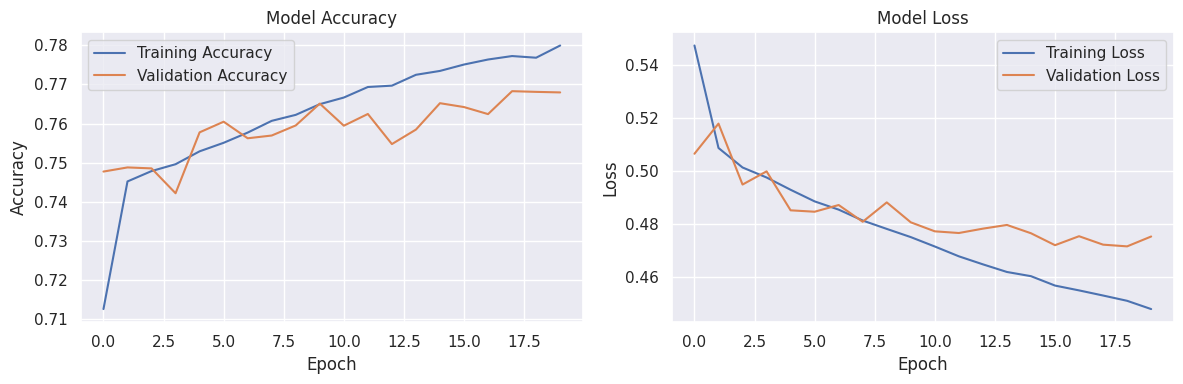

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

> Hasil plotting dari accuracy dan loss model per epoch

In [ ]:
y_pred_lstm_probs = lstm_model.predict(X_test)
y_pred_lstm = [1 if prob > 0.5 else 0 for prob in y_pred_lstm_probs]

887/887 [==============================] - 31s 35ms/step


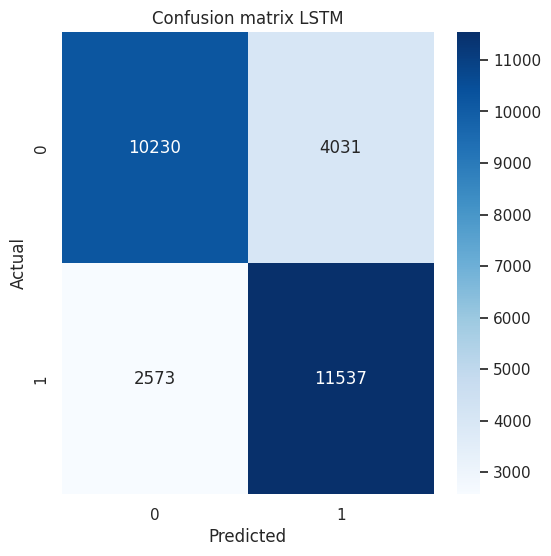

In [ ]:
print_conf(y_test, y_pred_lstm, [0, 1], title="Confusion matrix LSTM")

In [ ]:
print(metrics.classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76     14261
           1       0.74      0.82      0.78     14110

    accuracy                           0.77     28371
   macro avg       0.77      0.77      0.77     28371
weighted avg       0.77      0.77      0.77     28371



# Save Model To Pickle

In [ ]:
pick_insert = open('/content/drive/MyDrive/Kuliah/Semester 4/NLP/Pickle/LSTM.pkl','wb')
pickle.dump(lstm_model, pick_insert)
pick_insert.close()

#Predict New Data

# Preprocess New Data Function

In [ ]:
def load_abbreviations(file_path):
    with open(file_path, 'r') as file:
        abbreviations = json.load(file)
    return abbreviations

abbreviations = load_abbreviations(ABBREVIATIONS_PATH)

def fix_slang(text):
    if isinstance(text, str):
        words = text.split()
        fixed_words = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in words]
        return ' '.join(fixed_words)
    return text

In [ ]:
spell = SpellChecker()

def correct_typos(text):
    corrected_text = []
    for word in text.split():
        corrected_word = spell.correction(word)
        corrected_text.append(corrected_word)
    return ' '.join(corrected_text)

In [ ]:
def clean_text(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('\n', '', text)
    text = re.sub('RT', '', text)
    text = re.sub("[^a-zA-Z^']", " ", text)
    text = re.sub(" {2,}", " ", text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

In [ ]:
def tokenize_text(text):
    return word_tokenize(text)

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

In [ ]:
eng_stopwords = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in eng_stopwords]

# Predict

In [ ]:
input_tweet = [
    "Black people are losers",
    "You're a good person.",
    "I h8 u so much, you're a worthless piece of shit with a vagina!",
    "Great job on the project, keep it up!"
]

def preProcessText(input_tweet):
    new_tweets = []
    for tw in input_tweet:
        print(f"Input Text: {tw}")
        tw_slang = fix_slang(tw)
        print(f"Fix Slang: {tw_slang}")
        tw_typo = correct_typos(tw_slang)
        print(f"Correct Typo: {tw_typo}")
        tw_clean = clean_text(tw_typo)
        print(f"Clean Text: {tw_clean}")
        tw_tokenize = tokenize_text(tw_clean)
        print(f"Tokenize: {tw_tokenize}")
        tw_lemma = lemmatize_tokens(tw_tokenize)
        print(f"Lemmatize Tokens: {tw_lemma}")
        tw_stopwords = remove_stopwords(tw_lemma)
        print(f"Remove Stopwords: {tw_stopwords}")
        tw_final = ' '.join(tw_stopwords)
        new_tweets.append(tw_final)
        print("\n")
    return new_tweets

def predictNewData(input_tweet):
    processed_tweets = preProcessText(input_tweet)

    pick_read = open('/content/drive/MyDrive/Kuliah/Semester 4/NLP/Pickle/LSTM.pkl','rb')
    model = pickle.load(pick_read)
    pick_read.close()

    sequences = tokenizer.texts_to_sequences(processed_tweets)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    input_prediction = model.predict(padded_sequences)
    input_prediction = np.argmax(input_prediction, axis=1)

    for i in range(len(input_tweet)):
        print(f"\nInput Text: {input_tweet[i]}")
        print(f"Processed Text: {processed_tweets[i]}")
        if input_prediction[i] == 1:
            print("Prediction: Hate Speech!\n")
        else:
            print("Prediction: Not a Hate Speech.\n")

predictNewData(input_tweet)


Input Text: Black people are losers
Fix Slang: Black people are losers
Correct Typo: Black people are losers
Clean Text: black people are losers
Tokenize: ['black', 'people', 'are', 'losers']
Lemmatize Tokens: ['black', 'people', 'are', 'loser']
Remove Stopwords: ['black', 'people', 'loser']


Input Text: You're a good person.
Fix Slang: you are a good person.
Correct Typo: you are a good person
Clean Text: you are a good person
Tokenize: ['you', 'are', 'a', 'good', 'person']
Lemmatize Tokens: ['you', 'are', 'a', 'good', 'person']
Remove Stopwords: ['good', 'person']


Input Text: I h8 u so much, you're a worthless piece of shit with a vagina!
Fix Slang: I hate you so much, you are a worthless piece of shit with a vagina!
Correct Typo: I hate you so much you are a worthless piece of shit with a vagina
Clean Text: i hate you so much you are a worthless piece of shit with a vagina
Tokenize: ['i', 'hate', 'you', 'so', 'much', 'you', 'are', 'a', 'worthless', 'piece', 'of', 'shit', 'with', 

1/1 [==============================] - 1s 1s/step

Input Text: Black people are losers
Processed Text: black people loser
Prediction: Not a Hate Speech.


Input Text: You're a good person.
Processed Text: good person
Prediction: Not a Hate Speech.


Input Text: I h8 u so much, you're a worthless piece of shit with a vagina!
Processed Text: hate much worthless piece shit vagina
Prediction: Not a Hate Speech.


Input Text: Great job on the project, keep it up!
Processed Text: great job project keep
Prediction: Not a Hate Speech.

